### Chapter 2 Questions



All Imports will be located here

In [1]:
%matplotlib inline

import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

import numpy as np

import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score

from tqdm.autonotebook import tqdm

import time

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

torch.manual_seed(1)

device = torch.device("cpu")

if(torch.cuda.is_available()):
    device = torch.device("cuda")

print(f"Torch Device: {device}")

Torch Device: cuda


In [2]:
# code provided from the inChapter notebook. 
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

## Code provided from the "ildmam.py" file. See here: https://github.com/EdwardRaff/Inside-Deep-Learning/blob/main/idlmam.py
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

### Question 3

Write a new function resume_simple_network that loads a checkpoint_file from disk, restores both the optimizer and model states, and continues training to a specified total number of epochs. So if the model is saved after 20 epochs, and you specify 30 epochs, it should perform only 10 more epochs of training. 

In [3]:
# Simple training loop for the purpose of the assignment
def simple_train_for_epoch(epoch, model, optimizer, loss_function, start_epoch=0):
    print(f"Training running for {epoch} epochs")
    train_time_start = time.time()
    for epoch in tqdm(range(start_epoch, start_epoch + epoch), desc="Epoch"):
        model = model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(data_loader, desc="Batch", leave=False):
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)

            optimizer.zero_grad()


            y_hat = model(inputs)

            loss = loss_function(y_hat, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    train_time_stop = time.time()
    return train_time_stop - train_time_start

##### Note:
I would like to note that I do understand that this is a bit janky with how I use the model as a param, but that's mostly because I need a reference to the current network's shape. In the real world, I would define a class for the model, save some infromation about the model itself so that the function could recreate the model and THEN load the state dicts onto it. For now this will surffice as this quickly becomes an engineering problem and not a data science one. 

In [4]:
# NEW FUNCTION FOR ASSIGNMENT
def resume_simple_network(checkpoint_filename, model, optimizer, epoch):
    print(f"Loading network information from {checkpoint_filename}")
    data = torch.load(checkpoint_filename)
    train_epoch = data['results']['epoch'][-1]
    if train_epoch >= epoch:
        print(f"Model has already been trained to {train_epoch} which is greater than or equal to {epoch}")
        return
    
    model.state_dict = data['model_state_dict']
    optimizer.state_dict = data['optimizer_state_dict']
    simple_train_for_epoch(epoch - train_epoch, model, optimizer, loss_function, start_epoch=train_epoch)
    

In [5]:
model = nn.Sequential(nn.Linear(2, 30),
                      nn.ReLU(),
                      nn.Linear(30, 30),
                      nn.ReLU(),
                      nn.Linear(30, 2)  
)

X, y = make_blobs(n_samples=300, centers=2, n_features=2, random_state=0)
dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
data_loader = DataLoader(dataset, batch_size=30, shuffle=True) 
loss_function = nn.CrossEntropyLoss()

# run for 20 iterations
inital_epoch_count = 20

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

model.to(device)

to_track = ["epoch", "total time"]
results = {}
for item in to_track:
    results[item] = []

    
# Training
training_time = simple_train_for_epoch(inital_epoch_count, model, optimizer, loss_function)
results["total time"].append(training_time)
results['epoch'].append(inital_epoch_count)

checkpoint_filename = f"checkpoint_{inital_epoch_count}_model.pt"

print(f"Saving to model to {checkpoint_filename}")
# Save model at current count of 20
torch.save({
    'epoch': inital_epoch_count,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'results': results
}, checkpoint_filename)



Training running for 20 epochs


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Saving to model to checkpoint_20_model.pt


In [6]:
new_model_instance = nn.Sequential(nn.Linear(2, 30),
                      nn.ReLU(),
                      nn.Linear(30, 30),
                      nn.ReLU(),
                      nn.Linear(30, 2)  
)

new_model_instance.to(device)

new_optimizer_instance = torch.optim.SGD(new_model_instance.parameters(), lr=0.001)

resume_simple_network(checkpoint_filename, new_model_instance, new_optimizer_instance, 30)


Loading network information from checkpoint_20_model.pt
Training running for 10 epochs


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/10 [00:00<?, ?it/s]

### Question 4

When performing experiments, we may want to go back and try versions of our model from different epochs, especially if we are trying to determine when some weird behavior started to occur. Modify the train_simple_network function to take a new argument checkpoint_every_x that saves a version of the model every x epochs with different filenames. That way, you can go back and load a specific version without filling your hard drive with a model for every epoch. 

In [7]:
# Base code pulled from the book's offical Github for chapter 2. 
# https://github.com/EdwardRaff/Inside-Deep-Learning/blob/main/Chapter_2.ipynb 
# See box 24 in the above notebook.

def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, checkpoint_every_x=None):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
                    
        ### CHECKPOINT CODE
        if checkpoint_every_x is not None and epoch % checkpoint_every_x == 0:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, f"checkpoint_{epoch}_{checkpoint_file}")
        ### CHECKPOINT CODE
            
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

#### Note: 
This is pretty easy as we just add a quick check to the end of the training loop. Common convention is to store the epoch number as a part of the checkpoint name. I didn't want to mock out it working, but it should be obvious it will save every __x__ epochs. 

# Chapter 3 Questions

### Question 2

Load the CIFAR10 dataset from torchvision, and try to build your own CNN. Try using 2 to 10 layers of convolutions and 0 to 2 rounds of max pooling. What seems to work best? 

In [34]:
transform = transforms.Compose([transforms.ToTensor()])

cifar_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 4
cifar_train_loader =  DataLoader(cifar_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
cifar_test_loader =  DataLoader(cifar_test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


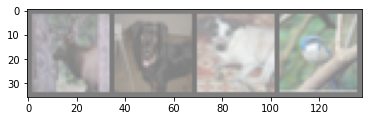

[deer][dog][dog][bird]


In [35]:
## Code from pytrch cifar10 tutorial 
## https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# display images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

iterator = iter(cifar_train_loader)
images, labels = next(iterator)

    
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(''.join(f'[{classes[labels[j]]}]' for j in range(batch_size)))

### Note to grader!

I've been thinking as I do this investigation, if theres an easy way to generate a permuation of layers and then run tests across all of them at once. I could write it myself, but I bet that it's a thing. Do you, __the grader__, have any feedback on this?

I didn't think it was a big issue to just copy and paste the code around here to test thigns, but ideally I think copy and pasting is a waste of time. Something something don't repeat yourself. 

In [36]:
loss_func = nn.CrossEntropyLoss()

D = 32*32 #32 * 32 images 
#How many channels are in the input?
C = 3
#How many classes are there?
classes = 10
#How many filters should we use
filters = 6
#how large should our filters be?
K = 5
#for comparison, lets define a linear model of similar complexity


# example from ifar10 tutorial on pytorch's website
model_1 = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.MaxPool2d(2),
    nn.Conv2d(6, 16, 5),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)

# inital book example
model_2 = nn.Sequential(
    nn.Conv2d(C, filters, K, padding=K//2),
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(filters*D, classes),
)

# book Cnn pool example
model_3 = nn.Sequential( 
    nn.Conv2d(C, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.MaxPool2d(2), 
    nn.Conv2d(filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(2*filters*D//(4**2), classes),
)

# Two layers ~ no pooling
model_4 = nn.Sequential(
    nn.Conv2d(C, filters, K, padding=K//2),
    nn.Tanh(),
    nn.Conv2d(filters, filters, K, padding=K//2),
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(filters*D, classes),
)

# Two layers 1 pool
model_5 = nn.Sequential(
    nn.Conv2d(C, filters, K, padding=K//2),
    nn.Tanh(),
    nn.Conv2d(filters, filters, K, padding=K//2),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear((filters*D)//4, classes),
)

# 6 layers 2 pools
model_6 = nn.Sequential(
    nn.Conv2d(C, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.MaxPool2d(2), 
    nn.Conv2d(filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(2*filters*D//(4**2), classes),
)

# 10 convolutions and 2 pools
model_7 = nn.Sequential(
    nn.Conv2d(C, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.MaxPool2d(2), 
    nn.Conv2d(filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.MaxPool2d(2),
    nn.Conv2d(2*filters, 4*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(4*filters, 4*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Flatten(),
    nn.Linear(4*filters*(D//(2**4)), classes),
)

# 10 convolutions and 1 pools
model_8 = nn.Sequential(
    nn.Conv2d(C, filters, K, padding=3//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=3//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=3//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=3//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=3//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=3//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=3//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=3//2), 
    nn.Tanh(), 
    nn.MaxPool2d(2),
    nn.Conv2d(filters, 2*filters, K, padding=3//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=3//2), 
    nn.Tanh(), 
    nn.Flatten(),
    nn.Linear(filters*D//32, classes),
)

# 10 covolutions and 0 pools
model_9 = nn.Sequential(
    nn.Conv2d(C, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2),  
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2),  
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Flatten(),
    nn.Linear(filters*D, classes),
)



models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9]

In [37]:
results = []

# I have a substantial GPU at home so training did not take too long....
for model_instance in models:
    result = train_simple_network(model_instance, 
                                  loss_func,
                                  cifar_train_loader,
                                  test_loader=cifar_train_loader,
                                  score_funcs={'Accuracy': accuracy_score},
                                  device=device,
                                  epochs=20)
    results.append(result)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/12500 [00:00<?, ?it/s]

In [38]:
results

[    epoch  total time  train loss  test loss  train Accuracy  test Accuracy
 0       0   19.750192    2.229754   2.020747         0.15228        0.25840
 1       1   41.542737    1.927765   1.824553         0.30060        0.34394
 2       2   63.343352    1.729199   1.626346         0.37942        0.41300
 3       3   85.295675    1.587831   1.539210         0.42814        0.45012
 4       4  106.185945    1.502990   1.480051         0.45922        0.46966
 5       5  128.169044    1.434475   1.400897         0.48158        0.49586
 6       6  150.010201    1.374182   1.332209         0.50830        0.52384
 7       7  170.897322    1.321276   1.271046         0.52814        0.54706
 8       8  193.221774    1.273387   1.220849         0.54624        0.56914
 9       9  215.181439    1.232361   1.189534         0.56146        0.57924
 10     10  237.018033    1.190736   1.154438         0.57996        0.59238
 11     11  258.476724    1.153606   1.091909         0.59392        0.61766

In [39]:
best_index = 0
best_accuracy = 0
for index, result in enumerate(results):
    test_accuracy = result.loc[19][5]
    if (test_accuracy > best_accuracy):
        best_accuracy = test_accuracy
        best_index = index

print(f"Model: model_{best_index+1}")
results[best_index]

Model: model_7


,epoch,total time,train loss,test loss,train Accuracy,test Accuracy
0,0,36.757075,2.302764,2.302434,0.09854,0.10000
1,1,73.953304,2.279330,2.331870,0.12134,0.13538
2,2,110.410625,1.985694,1.859069,0.26124,0.30688
3,3,147.226489,1.755993,1.664504,0.35392,0.37986
4,4,183.541898,1.603474,1.518735,0.40932,0.44052
5,5,219.585614,1.487726,1.454081,0.45640,0.47412
6,6,255.689728,1.396537,1.361550,0.49514,0.51472
7,7,292.006559,1.326736,1.308279,0.52264,0.53296
8,8,328.406870,1.264819,1.220991,0.54562,0.56494
9,9,364.492790,1.212423,1.209572,0.56632,0.57060


### Remarks

I had to run this expirement a number of time to find my errors. I think I had my batch size wrong which might have been causing issues with accuracy. I also found that I was testing against my training set as well which meant my accuracy was not truely reflected. After a lot of testing it seems that 10 conv and 2 pools did the best, but not signifiganntly against the other models.

### Question 3

Go through the transforms provided and see which makes sense for CIFAR10 via visual inspection. Do any transforms work for CIFAR10 that do not make sense for MNIST? 

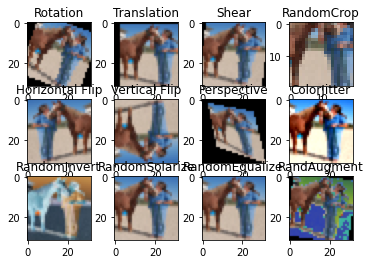

In [40]:
# Provided Transfroms in the textbook with added from pytorch documentation
sample_transforms = {
    "Rotation" : transforms.RandomAffine(degrees=45), 
    "Translation" : transforms.RandomAffine(degrees=0, translate=(0.1,0.1)), 
    "Shear": transforms.RandomAffine(degrees=0, shear=45), 
    "RandomCrop" : transforms.RandomCrop((20,20)), 
    "Horizontal Flip" : transforms.RandomHorizontalFlip(p=1.0), 
    "Vertical Flip": transforms.RandomVerticalFlip(p=1.0), 
    "Perspective": transforms.RandomPerspective(p=1.0), 
    "ColorJitter" : transforms.ColorJitter(brightness=0.9, contrast=0.9),
    # Added ones
    'RandomInvert': transforms.RandomInvert(),
    'RandomSolarize': transforms.RandomSolarize(threshold=192.0),
    'RandomEqualize': transforms.RandomEqualize(),
    # I didn't include the AutoAugment due to it allowing me specify a policy directly for
    # this dataset. It feels a bit like cheating.
    'RandAugment': transforms.RandAugment()
    
}

iterator = iter(cifar_train_loader)
images, labels = next(iterator)

image = images[0]

pil_img = transforms.ToPILImage()(image)

# display image before transformation
# base_fig, base_axis = plt.subplot(1,1)
# base_axis.imshow(image, cmap='gray')
# base_axis.set_title("Without modification")
f, axarr = plt.subplots(3,4)

for count, (name, t) in enumerate(sample_transforms.items()): 
    row = count % 4 
    col = count // 4 
    axarr[col,row].imshow(t(pil_img), cmap='gray') 
    axarr[col,row].set_title(name) 
plt.show()


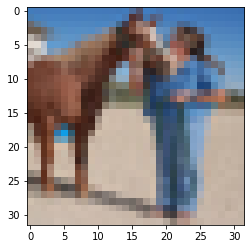

In [41]:
imgplot = plt.imshow(image.permute(1,2,0))

I actually really like the `RandAugment` and `ColorJutter` transforms. The ones that change the angle of the object could be good as well in order for the machine learning algorithm to learn multiple angles of how these objects look. 

While I didn't use it above in the list of `transforms` there is a RandomApply Transform where I could list all the ones I want to use. That might be better then soley using one transform. For now I'll be testing the `RandAugment` Transform. 

### Question 4

Train a new CIFAR10 model with the transforms you selected. What impact does this have on accuracy? 

In [44]:
model = nn.Sequential(
    nn.Conv2d(C, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(filters, filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.MaxPool2d(2), 
    nn.Conv2d(filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(2*filters, 2*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.MaxPool2d(2),
    nn.Conv2d(2*filters, 4*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Conv2d(4*filters, 4*filters, K, padding=K//2), 
    nn.Tanh(), 
    nn.Flatten(),
    nn.Linear(4*filters*(D//(2**4)), classes),
)

batch_size = 4

transformer = transforms.Compose([transforms.RandAugment(), transforms.ToTensor()]) 

train_transformed_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformer)
test_transformed_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformer)

train_loader =  DataLoader(cifar_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader =  DataLoader(cifar_test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
transform_results = train_simple_network(model, 
                                         loss_func,
                                         train_loader,
                                         test_loader=test_loader,
                                         score_funcs={'Accuracy': accuracy_score},
                                         device=device,
                                         epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

In [33]:
transform_results

,epoch,total time,train loss,test loss,train Accuracy,test Accuracy
0,0,3.465201,1.469886,1.478511,0.48294,0.4763
1,1,7.066766,1.462672,1.472995,0.48398,0.4802
2,2,10.503275,1.456146,1.463928,0.48788,0.4800
3,3,14.132317,1.450021,1.459435,0.48972,0.4821
4,4,17.592842,1.445046,1.455602,0.49092,0.4858
5,5,21.047378,1.439351,1.449824,0.49246,0.4900
6,6,24.631706,1.434595,1.444717,0.49426,0.4869
7,7,28.079799,1.429684,1.442655,0.49590,0.4883
8,8,31.507732,1.425115,1.439381,0.49898,0.4893
9,9,34.956034,1.421004,1.436496,0.49876,0.4956


### Remarks
I found that my accuracy didn't increase as much as I hope'd it would when compared against the models with no transforms. I got maybe a percent or so at best. Maybe because I didn't run the model for enough epochs or maybe the models themselves and their filters are not designed well enough to take advantage of the altered data. 

Plans going forward:

I am going to look into filter design for CNNs more to better understand if that is the source of the issue.
Run models for more epochs to see how accuracy changes when cm